In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [27]:
import numpy as np 
import pandas as pd
import cv2
import math

import os
from pathlib import Path

import time
from datetime import datetime

from data_explorer import *
from histogram import *
from imagereader import *


list( Path("../../../fastai-data/data/cifar10").iterdir())


In [28]:
cmap_grey = cc.cm.linear_grey_0_100_c0
cmap_grey_r = cc.cm.linear_grey_0_100_c0_r
noDisplaySamples = 5

print("Data:For imagenet - cifar10")
#path  = Path("../../../../fastai-data/data/dogscats/")

#path  = Path("../../../../fastai-data/data/cifar10") #corsaire
path  = Path("../../../fastai-data/data/cifar10") #corsaire
files = list( path.glob("**/*.jpg") )

dfhists = pd.read_csv(path / "histograms.csv", index_col=0 )
dfhists.drop("testOrTrain",axis=1,inplace=True)

hStats  = pd.read_csv(path / "histogram_statistics.csv", index_col =0 )

display(dfhists.head(2))
display(hStats.head(2))
#np.set_printoptions()


Data:For imagenet - cifar10


,0.0,0.015873,0.031746,0.047619,0.063492,0.079365,0.095238,0.111111,0.126984,0.142857,...,0.857143,0.873016,0.888889,0.904762,0.920635,0.936508,0.952381,0.968254,0.984127,1.0
2598_cat,25,39,45,61,52,53,31,53,48,37,...,32,43,72,51,41,37,56,50,55,31
332_cat,0,0,0,0,0,0,0,3,9,20,...,10,2,3,0,0,0,0,0,0,0


,hfilenames,hMean,hMedian,hMode,hModeW,hSD,hModeSkewness,hMedianSkewness
2598_cat,2598_cat,0.50302,0.49206,0.42857,0.43044,0.28975,0.25695,0.03782
332_cat,332_cat,0.48813,0.49206,0.53968,0.53747,0.15729,-0.32774,-0.02500


,bins,histMean,histSD,hist_smoothed,hist_no_outliers,histSD_no_outliers
0,0.000000,24.380967,114.068635,0.000000,0.000000,0.000000
1,0.015873,21.152600,58.488897,8.926975,8.721588,11.779101
2,0.031746,24.175200,50.523656,18.316814,17.443175,23.558203
3,0.047619,27.896817,49.280565,26.113745,26.164763,35.337304
4,0.063492,31.584667,48.857577,31.954753,34.886350,47.116405


,bins,histMean,histSD,hist_smoothed,hist_no_outliers,histSD_no_outliers
59,0.936508,22.756383,47.264913,9.830235,9.927142,11.226355
60,0.952381,21.948283,50.875437,7.346602,7.445357,8.419766
61,0.968254,21.421467,51.658159,4.980034,4.963571,5.613177
62,0.984127,24.503617,61.331318,2.651385,2.481786,2.806589
63,1.000000,64.911083,220.411623,0.000000,0.000000,0.000000


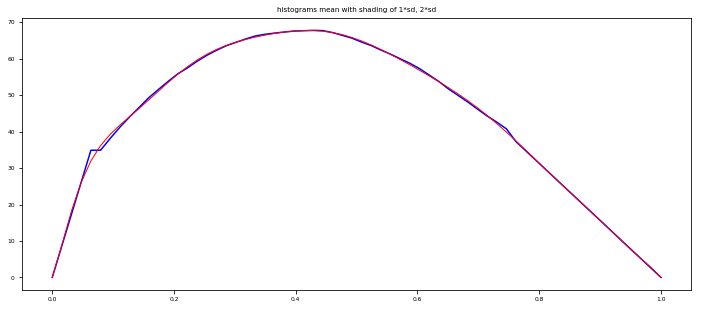

In [29]:
def smoothHistogram( bins, hist, sd, ixCutStart, ixCutEnd ):
    #remove extrem values at the end and start of the histogram
    h_clean  = hist.copy()
    sd_clean = sd.copy()
    
    h_clean[0:ixCutStart]  = np.linspace(0,hist[ixCutStart],ixCutStart)
    h_clean[-ixCutEnd-1:]  = np.linspace(hist[-ixCutEnd],0, ixCutEnd+1)
    sd_clean[0:ixCutStart] = np.linspace(0,sd_clean[ixCutStart],ixCutStart)
    sd_clean[-ixCutEnd-1:] = np.linspace(sd_clean[-ixCutEnd],0, ixCutEnd+1)

    #fit the histogram and force the start and end counts to zero
    p  = np.polyfit(bins, h_clean, deg=13)
    hs = np.polyval(p, bins)
    hs[0] = hs[-1] = 0
       
    data = pd.DataFrame(columns=["bins", "hist_smoothed", "hist_no_outliers", "histSD_no_outliers"] )
    data.bins=bins
    data.hist_smoothed = hs
    data.hist_no_outliers = h_clean
    data.histSD_no_outliers = sd_clean
    return data

def plotHistogramStats( df  ):
    fig = plt.figure(figsize = (12,5)) 
    ax1 = fig.add_subplot(111)
    ax1.set_title("histograms mean with shading of 1*sd, 2*sd")

    #ax1.fill_between(df.bins, df.hist_smoothed+df.histSD_no_outliers, df.hist_smoothed-df.histSD_no_outliers,facecolor='silver', alpha=0.25)
    #ax1.fill_between(df.bins, df.hist_smoothed+2*df.histSD_no_outliers, df.hist_smoothed-2*df.histSD_no_outliers, facecolor='silver', alpha=0.25)
    ax1.plot( df.bins, df.hist_no_outliers, color="b")
    #ax1.scatter( bins, h_clean, s=1, color="g")
    ax1.plot( df.bins, df.hist_smoothed, linewidth=1, color="r")

    
mHist = dfhists.mean(axis=0).values
sdHist= dfhists.std(axis=0).values
bins  = np.asarray(list(map(float, dfhists.columns)))

ixCutStart=5
ixCutEnd=15
dfMeanStd = smoothHistogram( bins, mHist, sdHist, ixCutStart=ixCutStart, ixCutEnd=ixCutEnd )
dfMeanStd.insert(1,"histMean",mHist)
dfMeanStd.insert(2,"histSD",sdHist)
display(dfMeanStd.head())
display(dfMeanStd.tail())
plotHistogramStats( dfMeanStd )




percentiles (0, 0):0.000 - 97:151.000


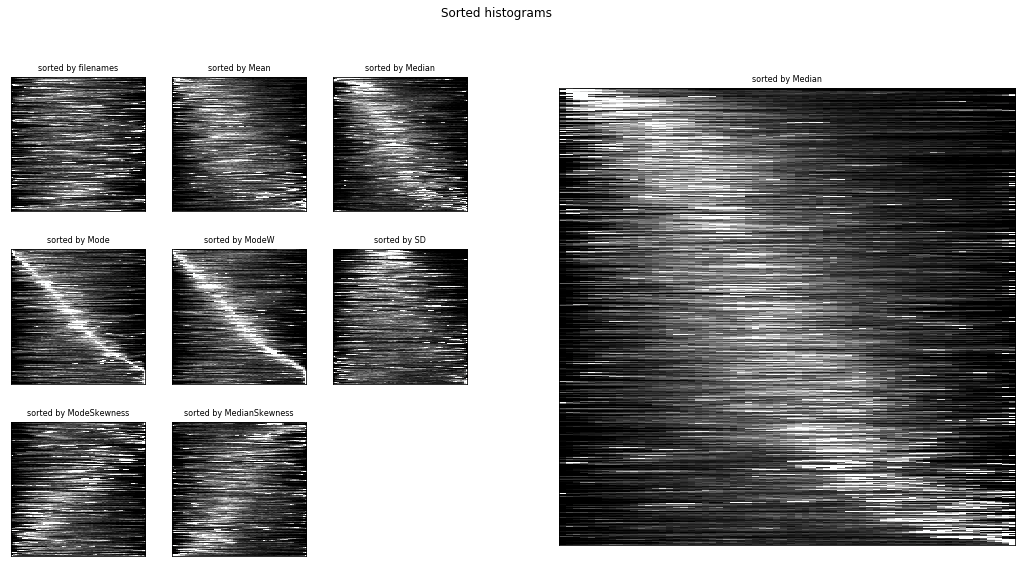

In [32]:
pmin = 0
pmax = 97
vMin = np.percentile(dfhists.values,pmin)
vMax = np.percentile(dfhists.values,pmax)
print(f"percentiles {pmin,pmin}:{vMin:.3f} - {pmax}:{vMax:.3f}")
selectSortBy="hMedian" # "hModeW"
plotSortedHistograms(dfhists, hStats, vMin, vMax, cmap=cmap_grey,selectSortBy=selectSortBy)


In [75]:
dfhists.index

Index(['3035_horse', '44175_airplane', '44674_automobile', '5494_airplane',
       '18854_airplane', '41740_airplane', '9246_cat', '6071_cat',
       '27873_airplane', '2439_frog',
       ...
       '46071_dog', '5540_bird', '25923_cat', '43458_airplane',
       '48001_airplane', '8258_airplane', '20074_automobile', '5224_airplane',
       '25016_airplane', '39514_bird'],
      dtype='object', length=60000)

In [82]:
# sort the histograms according to hModeW
c       = selectSortBy
ix      = hStats[c].argsort().values
hStats  = hStats.iloc[ix]
dfhists = dfhists.iloc[ix] 

#np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})
reader = ImageReader(outChannels=3)

nb=1
#ix       = int(dfhists.shape[0]-nb)
ix       = 0
filename = dfhists.index[ix]
nBins    = 64
hmax     = None
cdfMax   = 1.0

#imRGB    =  RGB2GRAY(reader.open(list( path.glob(f"**/{filename}.jpg") )[0]))
#filename = dfhists.index[0]
imRGB    = reader.open(list( path.glob(f"**/{filename}.*") )[0])
eqc      = EQC.HSV
histType = HISTOGRAMTYPE.CLASSIC

In [83]:
def fixedBinHistogram(im, vmin, vmax, nBins):
    hist, bins = np.histogram( np.unique(im.flatten()), np.linspace(vmin, vmax, nBins+1),  (vmin,vmax) )
    #hist, bins = np.histogram( im.flatten(), np.linspace(vmin, vmax, nBins+1),  (vmin,vmax) )
    return Histogram(hist, vmin, vmax, 0.5*(bins[:-1]+bins[1:]) )


In [84]:
def plotDiffHist( img, nBins ):
    img = img.flatten()
    u = np.unique(img)
    d = np.diff(u)
    print( f"unique values {len(u)}, min: {u.min():.9f}, min: {u.max():.9f} Diff: ideal {1.0/(len(u)-1):.9f}")
    print( f"median: {np.median(d):.9f}  mean: {np.mean(d):.9f}  std: {np.std(d):.9f} min: {np.min(d):.9f}  max: {np.max(d):.9f}  " )
    

Normal histogram: filename:3035_horse, vmin:0.001171875 ,vmax:0.998828125
unique values 232, min: 0.000000000, min: 1.000000000 Diff: ideal 0.004329004
median: 0.003921568  mean: 0.004329004  std: 0.002300674 min: 0.003921568  max: 0.031372547  


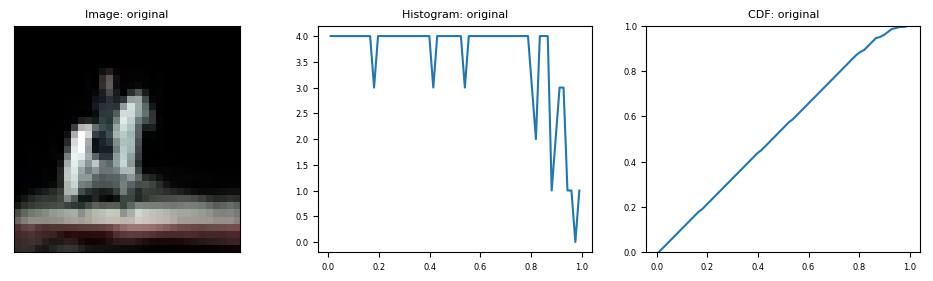

In [85]:
smoothHist = Histogram( dfMeanStd.hist_smoothed.values, vmin=0, vmax=1 )   

fig,axes = plt.subplots(nrows=1, ncols=3, figsize = (12,3), dpi=100 )
axes     = axes.flatten()

pre       = 0.3/256
vmin,vmax = pre, 1.0 - pre
cdfMax = 1
imRGBHist = fixedBinHistogram(imRGB, vmin, vmax, nBins)

print(f"Normal histogram: filename:{filename}, vmin:{vmin} ,vmax:{vmax}")
plotRow(axes[0:], "original", imRGB, imRGBHist, hmax, cdfMax, cmap_grey)
plotDiffHist(imRGB,50)



Global equalisation over the full pixel range: filename:3035_horse, vmin:0.001171875 ,vmax:0.998828125
unique values 1036, min: 0.000000000, min: 1.000000000 Diff: ideal 0.000966184
median: 0.000598252  mean: 0.000966184  std: 0.001135614 min: 0.000000001  max: 0.015029304  


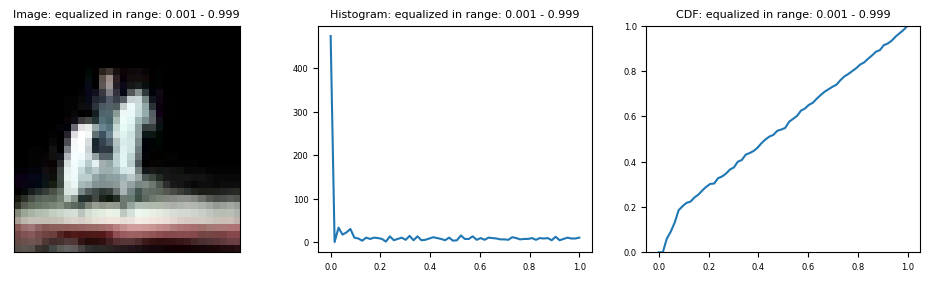

In [86]:
fig,axes = plt.subplots(nrows=1, ncols=3, figsize = (12,3), dpi=100 )
axes     = axes.flatten()
imEG, histEG = Equalizer(EQ.GLOBAL, eqc, histType, vmin, vmax, nBins).do( imRGB )

print(f"Global equalisation over the full pixel range: filename:{filename}, vmin:{vmin} ,vmax:{vmax}")
plotRow(axes[0:], f"equalized in range: {vmin:0.3f} - {vmax:0.3f}", imEG, histEG, hmax, cdfMax, cmap_grey)
plotDiffHist(imEG,nBins)


Histogram matching with the smoothed mean histogram for alle dogs&cats: filename:3035_horse, vmin:0.0012 ,vmax:0.9988
unique values 1036, min: 0.000000000, min: 1.000000000 Diff: ideal 0.000966184
median: 0.000584424  mean: 0.000966184  std: 0.001343992 min: 0.000000002  max: 0.021701440  


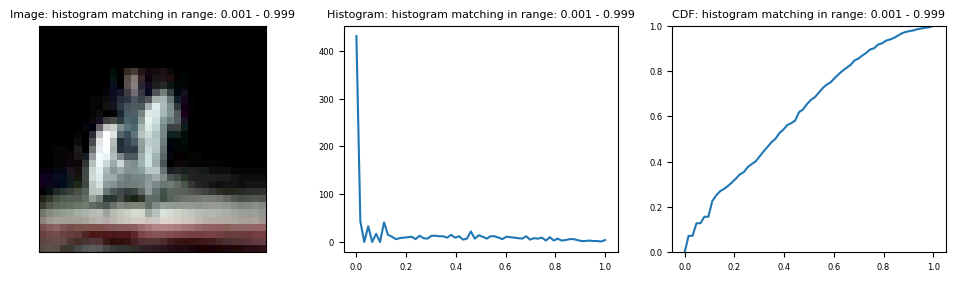

In [87]:
fig,axes = plt.subplots(nrows=1, ncols=3, figsize = (12,3), dpi=100 )
axes     = axes.flatten()

imEG, histEG = Equalizer(EQ.TRANSFER_IN_ONE_STEP, eqc, histType, vmin, vmax, nBins, smoothHist).do( imRGB )
                 
print(f"Histogram matching with the smoothed mean histogram for alle dogs&cats: filename:{filename}, vmin:{vmin:.4f} ,vmax:{vmax:.4f}")
plotRow(axes[0:], f"histogram matching in range: {vmin:0.3f} - {vmax:0.3f}", imEG, histEG, hmax, cdfMax, cmap_grey)
plotDiffHist(imEG,nBins)


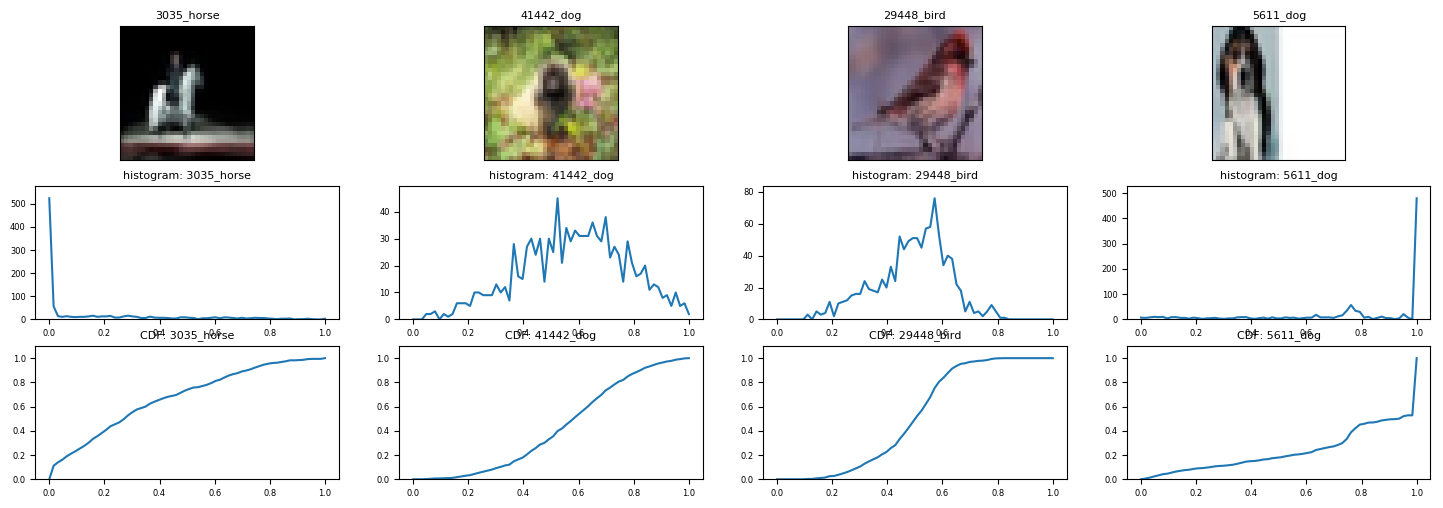

In [91]:
c       = "hModeW"
ix      = hStats[c].argsort().values
hStats  = hStats.iloc[ix]
dfhists = dfhists.iloc[ix] 

reader    = ImageReader(outChannels=3)
nBins     = 64
pre       = 0.3/256
vmin,vmax = pre, 1.0 - pre

ixm = int(dfhists.shape[0]/2)
filenames = dfhists.index[[0, ixm, ixm+1, dfhists.shape[0]-1]]

plotHistogramImage(path, reader, filenames, figsize=(18,6), ymax=None, cmap=cmap_grey, 
                   equalizer= Equalizer(EQ.NO, eqc, histType, vmin, vmax, nBins))

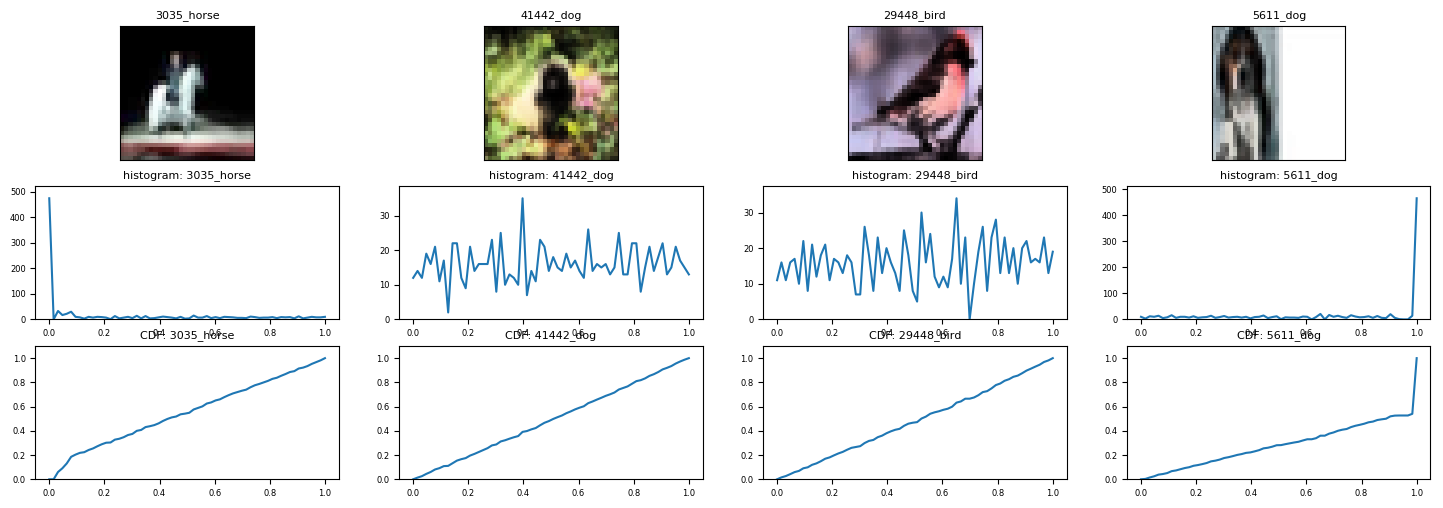

In [92]:
plotHistogramImage(path, reader, filenames, figsize=(18,6), ymax=None, cmap=cmap_grey, 
                   equalizer= Equalizer(EQ.GLOBAL, eqc, histType, vmin, vmax, nBins) )

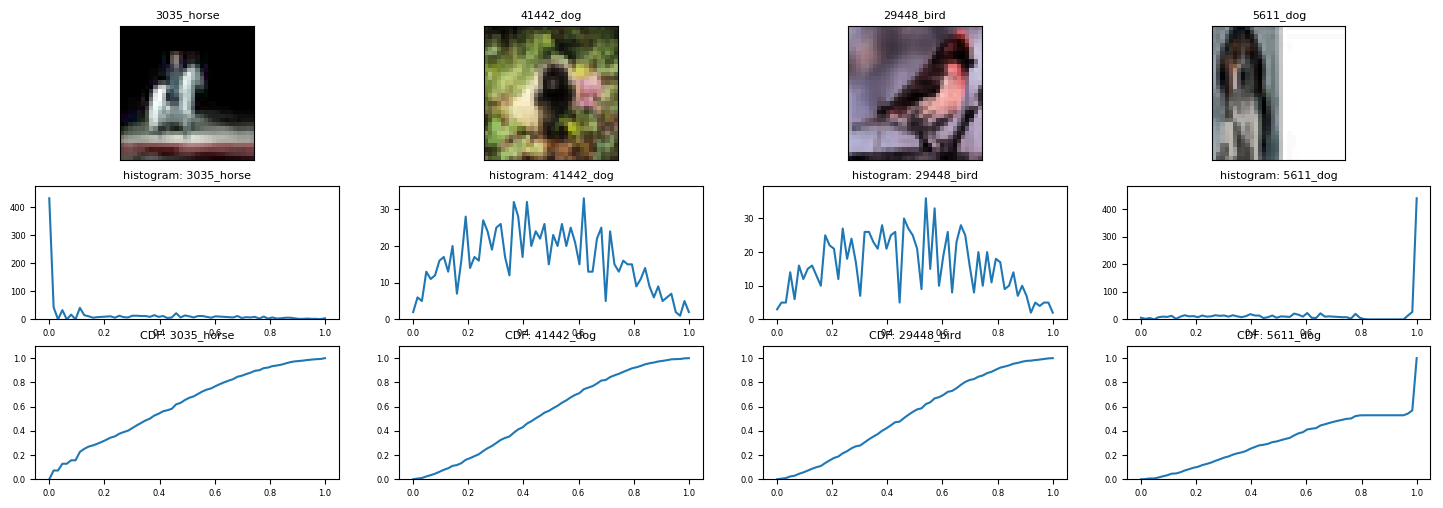

In [93]:
plotHistogramImage(path, reader, filenames, figsize=(18,6), ymax=None, cmap=cmap_grey, 
                   equalizer= Equalizer(EQ.TRANSFER_IN_ONE_STEP, eqc, histType, vmin, vmax, nBins, smoothHist) )

# Dataaugmentation

In [110]:
def augment(imSrc, dh, nb, histType, vmin = 0, vmax=1): 
    #ima = np.zeros((nb,im.shape[0],im.shape[1],im.shape[2]),dtype = np.float)
    ima = []
    ha  = []
    sampleStep = int( dh.shape[0]/ nb )
    ix  = np.arange(0, dh.shape[0], sampleStep)
    #r   = np.sort(random.random_intergers(0,df.shape[0], nb }))
    for i in range(nb) :
        trgHist  = Histogram( dh.iloc[ix[i]].values, vmin=0.0, vmax=1.0 )  
        im, hist = Equalizer(EQ.TRANSFER_IN_ONE_STEP, eqc, histType, vmin, vmax, nBins, trgHist).do( imSrc )
        ima.append(im)
        ha.append(hist)
    return ima,ha

import matplotlib.gridspec as gridspec
def plotImageHistogramMosaic( ims, hists ):
    nb=len(hists)
    ncols = int(np.sqrt(nb))
    nrows = int(math.ceil(nb/ncols))

    fig = plt.figure(figsize=(12,24))

    gs = gridspec.GridSpec(nrows, ncols, height_ratios=np.zeros(nrows)+ 2, wspace=0.0, hspace=0.0)
    
    for i in range(nb):
        inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=gs[i], wspace=0.0, hspace=0.0)
        
        ax = plt.subplot(inner[0])
        ax.axis('off')
        ax.imshow(ims[i])

        ax = plt.subplot(inner[1])
        #ax.axis('off')
        ax.set_xticks([])
        ax.set_yticks([])    
        
        ax.plot( hists[i].middelBins, hists[i].hist, linewidth=0.5 )
    
    plt.show()

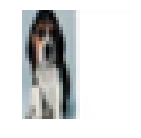

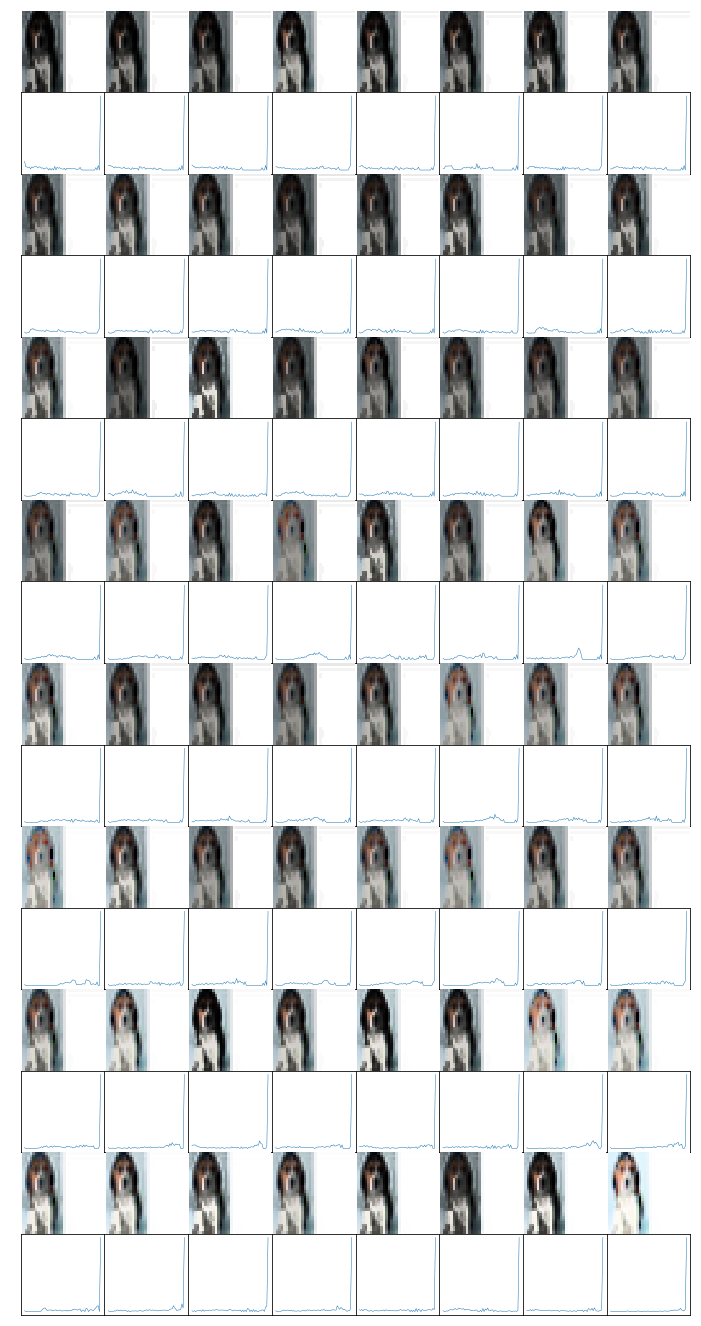

In [116]:
i        = int(dfhists.shape[0]-1)
filename = dfhists.index[i]
imRGB    = reader.open(list( path.glob(f"**/{filename}.*") )[0])

na = 64
pre       = 1e-6
vmin,vmax = pre, 1.0 - pre
ims,hists = augment(imRGB, dfhists, na, histType=HISTOGRAMTYPE.CLASSIC, vmin=vmin, vmax=vmax)


fig = plt.figure(figsize=(4,2))
plt.axis("off")
plt.imshow(imRGB,)
plt.show()
plotImageHistogramMosaic( ims, hists )

from ImageMosaic import *


def plotHistogramMosaic( hists ):
    nb=len(hists)
    ncols = int(np.sqrt(nb))
    nrows = int(math.ceil(nb/ncols))
    print(f"no histogram: {nb} nrows:{nrows} ncols:{ncols}")
    #print(f"nrows:{nrows} ncols:{ncols}")
    fig,axes = plt.subplots(nrows=nrows, ncols=ncols, figsize = (12,12) )
    axes = axes.flatten()
    for i in range(nb):
        ax = axes[i]
        ax.set_xticks([])
        ax.set_yticks([])    
        ax.plot( hists[i].middelBins, hists[i].hist, linewidth=0.5 )
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)
    #plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    plt.show()
    
    
nbThumbs = 100
ims,hists = augment(imRGB, dfhists, nbThumbs)
#create_mosaic(images, nrows=None, ncols=None, border_val=0, border_size=5,rows_first=True):
m = create_mosaic(ims, border_size=1)

fig = plt.figure(figsize=(4,2))
plt.imshow(imRGB)
plt.show()

fig = plt.figure(figsize=(12,12))
plt.imshow(m)
plt.show()

plotHistogramMosaic(hists)
           